In [3]:
pip install torch_geometric

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
You should consider upgrading via the '/opt/homebrew/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install torchvision 

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
You should consider upgrading via the '/opt/homebrew/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [5]:
import torch
import torchvision

In [6]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root = '/tmp/cora', name = 'CORA')
graph = dataset[0]

/var/folders/2c/7p5td__j1lv7c0vb5g74s7v00000gn/T/ipykernel_11488/4097211274.py:13: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sampled_nodes = random.sample(g.nodes, n_sample)


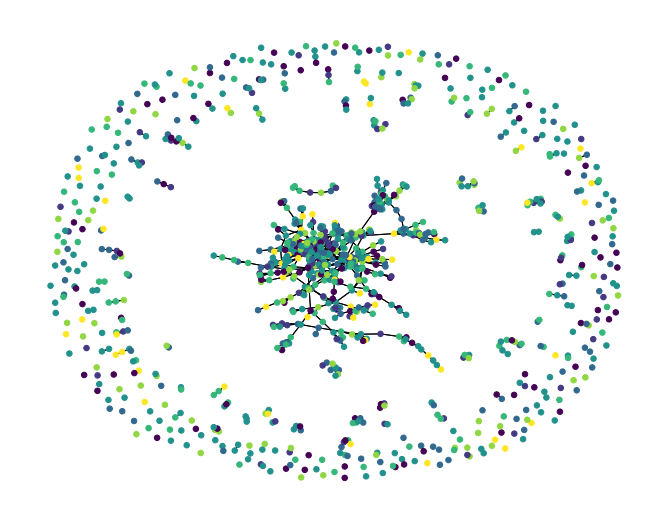

In [7]:
#for graph visualization
import random
from matplotlib import pyplot as plt
from torch_geometric.utils import to_networkx
import networkx as nx

def convert_to_networkx(graph, n_sample=None):

    g = to_networkx(graph, node_attrs=["x"])
    y = graph.y.numpy()

    if n_sample is not None:
        sampled_nodes = random.sample(g.nodes, n_sample)
        g = g.subgraph(sampled_nodes)
        y = y[sampled_nodes]

    return g, y


def plot_graph(g, y):

    plt.figure(figsize=(9, 7))
    nx.draw_spring(g, node_size=30, arrows=False, node_color=y)
    plt.show() 
    
    
g, y = convert_to_networkx(graph, n_sample=1000)
plot_graph(g, y)

#output - the node colors represent node classes (we have 7 of those)

Node Classification

Here, we are splitting the nodes into train valid, and test using RandomNodeSplit module from PyG (replacing the original split masks in the data as it has a too small train set)

In [64]:
import torch_geometric.transforms as T

split = T.RandomNodeSplit(num_val = 0.1, num_test = 0.2)
graph = split(graph)

Please note the data splits are written into mask attributes in the graph object (see the image below) instead of splitting the graph itself. Those masks are used for training loss calculation and model evaluation, whereas graph convolutions use entire graph data.

In [65]:
graph

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

Baseline Model (MLP - Multilayer Perceptron) - before building the GCN, we are training MLP, this model will ignore any nodes connections and only use word vectors to classify the node labels. It has two hidden layers: 1) Linear qith ReLU activation 2) Output layer

In [66]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
        nn.Linear(dataset.num_node_features, 64),
        nn.ReLU(),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Linear(32, dataset.num_classes)
        )

    def forward(self, data):
        x = data.x  # only using node features (x)
        output = self.layers(x)
        return output

We are defining training and evaluation functions with a normal Pytorch train/eval setup

In [67]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [85]:
def train_node_classifier(model, graph, optimizer, criterion, n_epochs = 200):
    loss_list = []
    X_ax = []
    val_acc =[]
    for epoch in range(1, n_epochs + 1):
        model.train()
        optimizer.zero_grad()
        out = model(graph)
        loss = criterion(out[graph.train_mask], graph.y[graph.train_mask])
        loss.backward()
        optimizer.step()
        
        loss_list.append(loss)
        X_ax.append(epoch)
        
        pred = out.argmax(dim = 1)
        acc = eval_node_classifier(model, graph, graph.val_mask)
        val_acc.append(acc)
        if epoch % 10 == 0:
            print(f'Epoch: {epoch:03d}, Train Loss: {loss:.3f}, Val Acc: {acc:.3f}')
    return model, loss_list, X_ax, val_acc

def eval_node_classifier(model, graph, mask):
    model.eval()
    pred = model(graph).argmax(dim = 1)
    correct = (pred[mask] == graph.y[mask]).sum()
    acc = int(correct) / int(mask.sum())
    
    return acc

mlp = MLP().to(device)
optimizer_mlp = torch.optim.Adam(mlp.parameters() , lr = 0.01, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
mlp, list_loss, X_ax, val_acc = train_node_classifier(mlp, graph, optimizer_mlp, criterion, n_epochs=150)

test_acc = eval_node_classifier(mlp, graph, graph.test_mask)
print(f'Test Acc: {test_acc:.3f}')

Epoch: 010, Train Loss: 0.839, Val Acc: 0.664
Epoch: 020, Train Loss: 0.086, Val Acc: 0.749
Epoch: 030, Train Loss: 0.015, Val Acc: 0.738
Epoch: 040, Train Loss: 0.012, Val Acc: 0.760
Epoch: 050, Train Loss: 0.014, Val Acc: 0.734
Epoch: 060, Train Loss: 0.013, Val Acc: 0.749
Epoch: 070, Train Loss: 0.011, Val Acc: 0.734
Epoch: 080, Train Loss: 0.010, Val Acc: 0.742
Epoch: 090, Train Loss: 0.008, Val Acc: 0.731
Epoch: 100, Train Loss: 0.007, Val Acc: 0.734
Epoch: 110, Train Loss: 0.007, Val Acc: 0.745
Epoch: 120, Train Loss: 0.006, Val Acc: 0.745
Epoch: 130, Train Loss: 0.006, Val Acc: 0.738
Epoch: 140, Train Loss: 0.006, Val Acc: 0.734
Epoch: 150, Train Loss: 0.006, Val Acc: 0.738
Test Acc: 0.725


GCN on Node Classification

Here, we are training GCN and comparing its performance to MLP. We are using a very simple model having two graph convolution layers and ReLU activation between them

Epoch: 010, Train Loss: 1.096, Val Acc: 0.830
Epoch: 020, Train Loss: 0.464, Val Acc: 0.893
Epoch: 030, Train Loss: 0.260, Val Acc: 0.875
Epoch: 040, Train Loss: 0.189, Val Acc: 0.886
Epoch: 050, Train Loss: 0.156, Val Acc: 0.893
Epoch: 060, Train Loss: 0.140, Val Acc: 0.889
Epoch: 070, Train Loss: 0.129, Val Acc: 0.889
Epoch: 080, Train Loss: 0.120, Val Acc: 0.889
Epoch: 090, Train Loss: 0.112, Val Acc: 0.886
Epoch: 100, Train Loss: 0.105, Val Acc: 0.882
Epoch: 110, Train Loss: 0.099, Val Acc: 0.882
Epoch: 120, Train Loss: 0.093, Val Acc: 0.878
Epoch: 130, Train Loss: 0.089, Val Acc: 0.875
Epoch: 140, Train Loss: 0.085, Val Acc: 0.875
Epoch: 150, Train Loss: 0.082, Val Acc: 0.875
Epoch: 160, Train Loss: 0.079, Val Acc: 0.875
Epoch: 170, Train Loss: 0.077, Val Acc: 0.871
Epoch: 180, Train Loss: 0.074, Val Acc: 0.867
Epoch: 190, Train Loss: 0.072, Val Acc: 0.867
Epoch: 200, Train Loss: 0.070, Val Acc: 0.867
Test Acc: 0.876


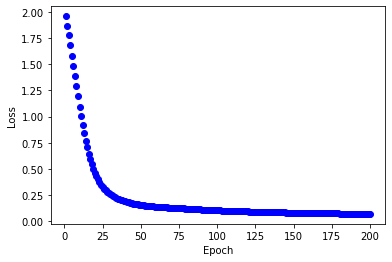

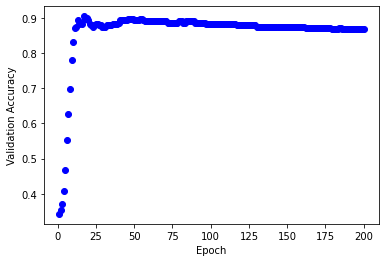

In [88]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        output = self.conv2(x, edge_index)

        return output
    
    
gcn = GCN().to(device)
optimizer_gcn = torch.optim.Adam(gcn.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
gcn,list_loss, X_ax,val_acc   = train_node_classifier(gcn, graph, optimizer_gcn, criterion)

test_acc= eval_node_classifier(gcn, graph, graph.test_mask)
print(f'Test Acc: {test_acc:.3f}')

list_loss = [t.item() for t in list_loss]
# val_acc = [t.item() for t in val_acc]

plt.scatter(X_ax, list_loss, c ="blue")
plt.xlabel("Epoch")
plt.ylabel("Loss")
# To show the plot
plt.show()


plt.scatter(X_ax, val_acc, c ="blue")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
# To show the plot
plt.show()


In [70]:
def eval_node_classifier(model, graph, mask):
    model.eval()
    with torch.no_grad():
        pred = model(graph)
        pred_labels = pred.argmax(dim=1).cpu().numpy()
        true_labels = graph.y.cpu().numpy()

    pred_labels = pred_labels[mask]
    true_labels = true_labels[mask]

    accuracy = (pred_labels == true_labels).sum() / mask.sum()
    precision = precision_score(true_labels, pred_labels, average='macro')
    recall = recall_score(true_labels, pred_labels, average='macro')
    f1 = f1_score(true_labels, pred_labels, average='macro')

    return accuracy, precision, recall, f1


**Link Prediction**

In [73]:
test_acc, test_precision, test_recall, test_f1 = eval_node_classifier(gcn, graph, graph.test_mask)
print(f'Test Accuracy: {test_acc:.3f}')
print(f'Test Precision: {test_precision:.3f}')
print(f'Test Recall: {test_recall:.3f}')
print(f'Test F1-score: {test_f1:.3f}')


Test Accuracy: 0.875
Test Precision: 0.853
Test Recall: 0.868
Test F1-score: 0.859


In [14]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(
            dim=-1
        )  # product of a pair of nodes on each edge

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()

In [49]:
from sklearn.metrics import roc_auc_score
from torch_geometric.utils import negative_sampling


def train_link_predictor(
    model, train_data, val_data, optimizer, criterion, n_epochs= 100
):
    list_loss = []
    X_axis = []
    list_AUC = []

    for epoch in range(1, n_epochs + 1):

        model.train()
        optimizer.zero_grad()
        z = model.encode(train_data.x, train_data.edge_index)

        # sampling training negatives for every training epoch
        neg_edge_index = negative_sampling(
            edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
            num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

        edge_label_index = torch.cat(
            [train_data.edge_label_index, neg_edge_index],
            dim=-1,
        )
        edge_label = torch.cat([
            train_data.edge_label,
            train_data.edge_label.new_zeros(neg_edge_index.size(1))
        ], dim=0)

        out = model.decode(z, edge_label_index).view(-1)
        loss = criterion(out, edge_label)
        loss.backward()
        optimizer.step()
        
        
        list_loss.append(loss)
        X_axis.append(epoch)


        val_auc = eval_link_predictor(model, val_data)

        if epoch % 10 == 0:
            print(f"Epoch: {epoch:03d}, Train Loss: {loss:.3f}, Val AUC: {val_auc:.3f}")

    return model, list_loss, X_axis, list_AUC


@torch.no_grad()
def eval_link_predictor(model, data):

    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()

    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())

In [25]:
""" deleting node split masks """

del graph.train_mask 
del graph.val_mask 
del graph.test_mask

In [30]:
split = T.RandomLinkSplit(
    num_val=0.05,
    num_test=0.1,
    is_undirected=True,
    add_negative_train_samples=False,
    neg_sampling_ratio=1.0,
)
train_data, val_data, test_data = split(graph)

In [31]:
print('train_data:', train_data)
print('val_data:', val_data)
print('test_data:', test_data)

train_data: Data(x=[2708, 1433], edge_index=[2, 8976], y=[2708], edge_label=[4488], edge_label_index=[2, 4488])
val_data: Data(x=[2708, 1433], edge_index=[2, 8976], y=[2708], edge_label=[526], edge_label_index=[2, 526])
test_data: Data(x=[2708, 1433], edge_index=[2, 9502], y=[2708], edge_label=[1054], edge_label_index=[2, 1054])


Epoch: 010, Train Loss: 0.664, Val AUC: 0.735
Epoch: 020, Train Loss: 0.586, Val AUC: 0.813
Epoch: 030, Train Loss: 0.510, Val AUC: 0.848
Epoch: 040, Train Loss: 0.476, Val AUC: 0.878
Epoch: 050, Train Loss: 0.459, Val AUC: 0.890
Epoch: 060, Train Loss: 0.443, Val AUC: 0.903
Epoch: 070, Train Loss: 0.432, Val AUC: 0.913
Epoch: 080, Train Loss: 0.426, Val AUC: 0.917
Epoch: 090, Train Loss: 0.418, Val AUC: 0.914
Epoch: 100, Train Loss: 0.414, Val AUC: 0.917


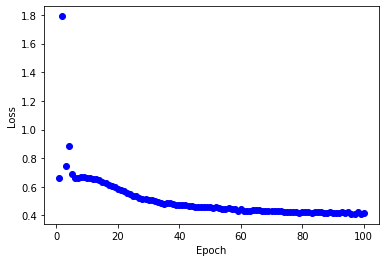

In [50]:
model = Net(dataset.num_features, 128, 64).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()

model, list_loss, X_axis, list_AUC = train_link_predictor(model, train_data, val_data, optimizer, criterion)

list_loss = [t.item() for t in list_loss]

plt.scatter(X_axis, list_loss, c ="blue")
plt.xlabel("Epoch")
plt.ylabel("Loss")
# To show the plot
plt.show()


In [51]:
test_auc = eval_link_predictor(model, test_data)
print(f"Test: {test_auc:.3f}")

Test: 0.916


In [21]:
print(f'Number of classes: {dataset.num_classes}')

Number of classes: 7


In [58]:
from itertools import combinations


In [62]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Evaluate the model on the test dataset
model.eval()
z = model.encode(test_data.x, test_data.edge_index)
out = model.decode(z, test_data.edge_label_index).view(-1).sigmoid()

# Convert the predicted probabilities to binary predictions
y_pred = out.detach().cpu().numpy() > 0.5

# Calculate precision, recall, and F-measure
precision = precision_score(test_data.edge_label.detach().cpu().numpy(), y_pred)
recall = recall_score(test_data.edge_label.detach().cpu().numpy(), y_pred)
f1 = f1_score(test_data.edge_label.detach().cpu().numpy(), y_pred)

print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1))


Precision: 0.7295
Recall: 0.9469
F1-score: 0.8241
